---

# Name - Shivansh Nautiyal
# PRN - 21070126086
# Batch - 2021-25

---

## Problem Statement

Experiment with different hyperparameters such as learning rate, batch size, and latent space dimension to see their effects on the VAE's performance for the MNIST dataset.

---
.

# Dataset Discription 
# MNIST Dataset Overview

The MNIST dataset is a widely used benchmark dataset in the field of machine learning and computer vision. It consists of a collection of 28x28 grayscale images of handwritten digits (0 to 9), along with their corresponding labels indicating the digit they represent. Here's a brief overview:

- **Size**: The dataset comprises 60,000 training images and 10,000 test images.
- **Image Format**: Each image is a 28x28 pixel grid, making a total of 784 pixels per image.
- **Labeling**: Each image is associated with a label indicating the digit it represents (0 to 9).
- **Usage**: MNIST is commonly used for tasks like digit recognition, classification, and as a benchmark for evaluating machine learning algorithms.

The MNIST dataset is often used as an introductory dataset for learning machine learning techniques due to its simplicity and accessibility. It has served as a foundation for numerous research papers, projects, and tutorials in the field of deep learning and image recognition.


In [ ]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [13]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)


# Structure of the VAE

In [14]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

---

## Implementing a Conditional Variational Autoencoder (CVAE)

After experimenting with various structures, the following architecture is derived from the paper "Auto-Encoding Variational Bayes" for implementing a Conditional Variational Autoencoder (CVAE).

The CVAE architecture involves modifying both the encoder and decoder networks to incorporate conditional information alongside the input data. Additionally, adjustments are made to the sampling process, reconstruction loss, and training procedure to account for the conditional nature of the model.

By following the principles outlined in the paper and incorporating conditional information into the VAE framework, the resulting CVAE can learn a structured latent space that captures both the variability in the input data and the conditional dependencies specified by the provided conditions (e.g., class labels).

This architecture enables more controlled and targeted generation of data samples based on specified conditions, making it particularly useful for tasks such as image generation and manpulation.

---
ation.



In [15]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [19]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [20]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [21]:
for epoch in range(1, 51):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 545.295469
Train Epoch: 1 [10000/60000 (17%)]	Loss: 190.162969
Train Epoch: 1 [20000/60000 (33%)]	Loss: 171.841973
Train Epoch: 1 [30000/60000 (50%)]	Loss: 163.672744
Train Epoch: 1 [40000/60000 (67%)]	Loss: 163.010537
Train Epoch: 1 [50000/60000 (83%)]	Loss: 162.375576
====> Epoch: 1 Average loss: 177.8276
====> Test set loss: 158.1827
Train Epoch: 2 [0/60000 (0%)]	Loss: 159.763584
Train Epoch: 2 [10000/60000 (17%)]	Loss: 157.112090
Train Epoch: 2 [20000/60000 (33%)]	Loss: 160.855352
Train Epoch: 2 [30000/60000 (50%)]	Loss: 153.194043
Train Epoch: 2 [40000/60000 (67%)]	Loss: 150.841211
Train Epoch: 2 [50000/60000 (83%)]	Loss: 153.102715
====> Epoch: 2 Average loss: 154.8499
====> Test set loss: 151.5282
Train Epoch: 3 [0/60000 (0%)]	Loss: 152.925469
Train Epoch: 3 [10000/60000 (17%)]	Loss: 148.401484
Train Epoch: 3 [20000/60000 (33%)]	Loss: 153.659971
Train Epoch: 3 [30000/60000 (50%)]	Loss: 145.705459
Train Epoch: 3 [40000/60000 (67%)]	Loss: 153.95

In [25]:
with torch.no_grad():
    z = torch.randn(64, 2)
    sample = vae.decoder(z)
    
    save_image(sample.view(64, 1, 28, 28), 'sample_' + '.png')

# output image
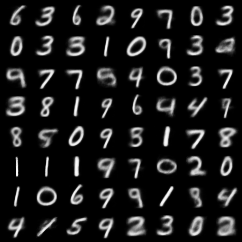

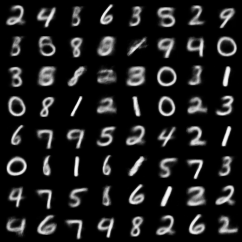

Random generated output